# WeatherPy
----

### Analysis
* As most pepole are aware, the weather becomes significantly warmer as one approaches the equator (0 Deg. Latitude). 
* For cities equi-distant from the equator however, the southern hemisphere is much warmer than it's northern hemisphere counter parts, given that the southern hemispehere at this time of year is in summer while the northern hemisphere is in winter. The Earths tilt is the reason why the seasons are reversed in the southern hemisphere.

* There is no strong relationship between latitude and humidity, but while we see high humidty at the equator and for cities equidistant of +/- 100 latitude, for those cities close to the equator there are no observations where the humidity is 0. 

* There are a handful of observations for cities in Russia have 0 humidity.  These are outliers in the scatter plot and I would question the validity of the humidity data point for these observations

* There is no strong relationship between latitude and cloudiness. 

* There is no strong relationship between latitude and wind speed.


In [2]:
%matplotlib inline

# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import datetime

# Import API key
from api_keys import api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "./output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

619

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
"""
Function that prints out a message banner

param1: decoration: a single char to use as the header and footer banner 
param2: message: the message to display

"""
def print_banner(decoration, message):
    print(decoration * len(message))
    print(message)
    print(decoration * len(message))

In [4]:
"""
Function to build the url by city name

param1: city_name: the cityname

returns: the fully formed url for the OpenWeatherMap API with the api_key and the city_name and units as imperial as query params
"""
def build_url_by_city_name(city_name):
    base_url = f'http://api.openweathermap.org/data/2.5/weather?appid={api_key}'
    return f"{base_url}&q={city_name}&units=imperial"

In [5]:
#Create an empty list
l = []

start_msg = 'Beginning Data Retrieval'
end_msg = 'Data Retrieval Complete'
interrupt_msg = 'Stopped processing at the request of the user'

print_banner(decoration='-', message=start_msg)

batch_size = 60
wait_time = 1
record_number = 0
record_group_number = 0

try:
    for i in range(0, len(cities), batch_size):
        record_group_number = record_group_number + 1
        print_banner(decoration='o', message=datetime.datetime.now().strftime('%m/%d/%Y %r'))
        for j in range(i, batch_size + i): 
            #sleep for 1 second per api call
            time.sleep(wait_time)                
           
            if j < len(cities):
                record_number = j + 1
                json_data = requests.get(build_url_by_city_name(cities[j])).json()
                if json_data['cod'] == '404':
                    print(f"City not found. Skipping {cities[j]} ...") 
                else:
                    print(f"Processing Record {record_number} of Set {record_group_number} | {json_data['name']}")
                    #Create an empty dictionary to store what we want from the json_data 
                    d = {}
                    d['id'] = json_data['id']
                    d['City'] = json_data['name']
                    d['Country'] = json_data['sys']['country']
                    d['Date'] = json_data['dt']
                    d['Humidity'] = json_data['main']['humidity']
                    d['Lat'] = json_data['coord']['lat']
                    d['Lng'] = json_data['coord']['lon']
                    d['Cloudiness'] = json_data['clouds']['all']
                    d['Max Temp'] = json_data['main']['temp_max']
                    d['Wind Speed'] = json_data['wind']['speed']
                    l.append(d)

except KeyboardInterrupt:
    print_banner(decoration='*', message=interrupt_msg)
except KeyError:
    if type(json_data) == dict:
        print(f"ERROR: {json_data['cod']}: {json_data['message']}")
    else:
        print('Something went wrong')
finally:  
    print_banner(decoration='-', message=end_msg)
    print_banner(decoration='o', message=datetime.datetime.now().strftime('%m/%d/%Y %r'))

------------------------
Beginning Data Retrieval
------------------------
oooooooooooooooooooooo
12/02/2018 09:19:31 AM
oooooooooooooooooooooo
Processing Record 1 of Set 1 | Kaitangata
Processing Record 2 of Set 1 | Sao Joao da Barra
Processing Record 3 of Set 1 | Thompson
Processing Record 4 of Set 1 | Vaini
Processing Record 5 of Set 1 | Atuona
Processing Record 6 of Set 1 | Klaksvik
Processing Record 7 of Set 1 | Hermanus
Processing Record 8 of Set 1 | Ushuaia
Processing Record 9 of Set 1 | Bluff
Processing Record 10 of Set 1 | Khatanga
Processing Record 11 of Set 1 | Mahebourg
Processing Record 12 of Set 1 | Torbay
Processing Record 13 of Set 1 | Uyuni
Processing Record 14 of Set 1 | Cabo San Lucas
Processing Record 15 of Set 1 | Rio de Janeiro
Processing Record 16 of Set 1 | Port-Gentil
Processing Record 17 of Set 1 | Cape Town
Processing Record 18 of Set 1 | Qaanaaq
Processing Record 19 of Set 1 | Punta Arenas
Processing Record 20 of Set 1 | Nikolskoye
Processing Record 21 of Se

Processing Record 191 of Set 4 | Port Augusta
Processing Record 192 of Set 4 | Grindavik
Processing Record 193 of Set 4 | Tailai
Processing Record 194 of Set 4 | Camacha
Processing Record 195 of Set 4 | Severo-Kurilsk
Processing Record 196 of Set 4 | Zyryanka
Processing Record 197 of Set 4 | Khakhea
Processing Record 198 of Set 4 | Pokhara
Processing Record 199 of Set 4 | Tuktoyaktuk
Processing Record 200 of Set 4 | Oksfjord
Processing Record 201 of Set 4 | Holme
City not found. Skipping cheuskiny ...
Processing Record 203 of Set 4 | Broome
Processing Record 204 of Set 4 | Kushiro
Processing Record 205 of Set 4 | Caronport
Processing Record 206 of Set 4 | Ust-Kut
Processing Record 207 of Set 4 | San Quintin
Processing Record 208 of Set 4 | Wichian Buri
Processing Record 209 of Set 4 | Rincon
Processing Record 210 of Set 4 | Chapais
Processing Record 211 of Set 4 | Buraydah
City not found. Skipping barentsburg ...
Processing Record 213 of Set 4 | Mar del Plata
Processing Record 214 of S

Processing Record 382 of Set 7 | Hervey Bay
Processing Record 383 of Set 7 | Flinders
Processing Record 384 of Set 7 | Nanortalik
Processing Record 385 of Set 7 | Hare Bay
Processing Record 386 of Set 7 | Jalu
Processing Record 387 of Set 7 | Karratha
Processing Record 388 of Set 7 | Berlevag
Processing Record 389 of Set 7 | Buchanan
Processing Record 390 of Set 7 | Kondagaon
Processing Record 391 of Set 7 | Lebu
Processing Record 392 of Set 7 | Mercedes
Processing Record 393 of Set 7 | Half Moon Bay
Processing Record 394 of Set 7 | Tabou
Processing Record 395 of Set 7 | Monsenhor Gil
Processing Record 396 of Set 7 | Charleville
Processing Record 397 of Set 7 | Port Shepstone
Processing Record 398 of Set 7 | Codrington
City not found. Skipping richard toll ...
Processing Record 400 of Set 7 | Altay
Processing Record 401 of Set 7 | Sorong
Processing Record 402 of Set 7 | Kutum
Processing Record 403 of Set 7 | Lloydminster
Processing Record 404 of Set 7 | Teya
City not found. Skipping ca

Processing Record 572 of Set 10 | Mokhsogollokh
Processing Record 573 of Set 10 | La Tuque
Processing Record 574 of Set 10 | Santiago del Estero
Processing Record 575 of Set 10 | Ibotirama
Processing Record 576 of Set 10 | Kumluca
Processing Record 577 of Set 10 | Tianpeng
Processing Record 578 of Set 10 | Shizunai
Processing Record 579 of Set 10 | Qinhuangdao
Processing Record 580 of Set 10 | Westport
Processing Record 581 of Set 10 | Kathu
Processing Record 582 of Set 10 | Mayor Pablo Lagerenza
Processing Record 583 of Set 10 | Praia
Processing Record 584 of Set 10 | Gumdag
City not found. Skipping ndele ...
Processing Record 586 of Set 10 | Maldonado
Processing Record 587 of Set 10 | Adiake
Processing Record 588 of Set 10 | Guangyuan
Processing Record 589 of Set 10 | Buin
Processing Record 590 of Set 10 | Umm Kaddadah
Processing Record 591 of Set 10 | Baykalsk
Processing Record 592 of Set 10 | Sabha
Processing Record 593 of Set 10 | Eldoret
City not found. Skipping one hundred mile 

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [6]:
df = pd.DataFrame(l)
df.to_csv(output_data_file, index=False)
#df = pd.read_csv(output_data_file)
df.head()

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed,id
0,Kaitangata,0,NZ,1543771172,94,-46.28,169.85,54.82,6.17,2208248
1,Sao Joao da Barra,75,BR,1543770000,65,-21.64,-41.05,82.40,16.11,3448903
2,Thompson,90,CA,1543768620,92,55.74,-97.86,21.20,2.24,6165406
3,Vaini,8,IN,1543770756,73,15.34,74.49,64.54,3.71,1273574
4,Atuona,24,PF,1543770751,99,-9.80,-139.03,81.24,15.35,4020109


### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [39]:
"""
Function to build the scatter plot based on the param values passed in

param1: x_axis
param2: y_axis
param3: title
param4: xlabel
param5. ylabel

"""
def build_scatter_plot(x_axis, y_axis, title, xlabel, ylabel):
    todays_date = datetime.date.today().strftime('%m/%d/%Y')
    plt.scatter(x=x_axis, y=y_axis, alpha=.75, edgecolors='black', linewidths=.75)
    plt.title(f"{title} ({todays_date})")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()

#### Latitude vs. Temperature Plot

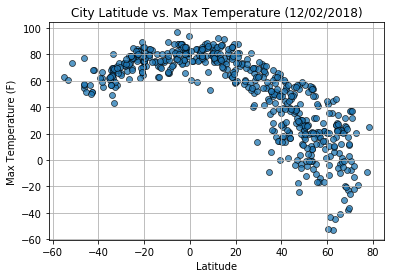

In [8]:
build_scatter_plot(x_axis=df['Lat']
                   , y_axis=df['Max Temp']
                   , title='City Latitude vs. Max Temperature'
                   , xlabel='Latitude'
                   , ylabel='Max Temperature (F)'
                  )  

# Save Figure
plt.savefig("./images/WeatherPy_latitude_v_max_temperature.png")

# Show Figure
plt.show()

#### Latitude vs. Humidity Plot

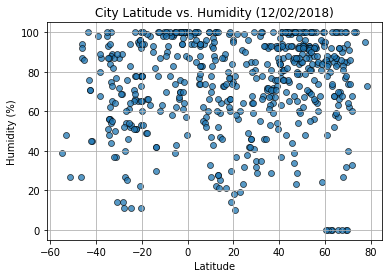

In [9]:
build_scatter_plot(x_axis=df['Lat']
                   , y_axis=df['Humidity']
                   , title='City Latitude vs. Humidity'
                   , xlabel='Latitude'
                   , ylabel='Humidity (%)'
                  )
# Save Figure
plt.savefig("./images/WeatherPy_latitude_v_humidity.png")

# Show Figure
plt.show()

#### Latitude vs. Cloudiness Plot

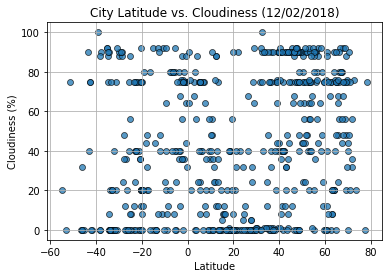

In [10]:
build_scatter_plot(x_axis=df['Lat']
                   , y_axis=df['Cloudiness']
                   , title='City Latitude vs. Cloudiness'
                   , xlabel='Latitude'
                   , ylabel='Cloudiness (%)'
                  ) 
# Save Figure
plt.savefig("./images/WeatherPy_latitude_v_cloudiness.png")

# Show Figure
plt.show()

#### Latitude vs. Wind Speed Plot

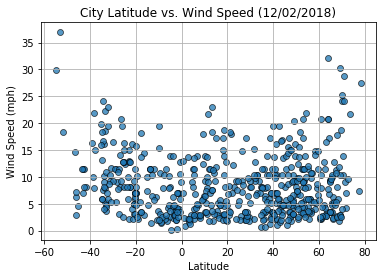

In [11]:
build_scatter_plot(x_axis=df['Lat']
                   , y_axis=df['Wind Speed']
                   , title='City Latitude vs. Wind Speed'
                   , xlabel='Latitude'
                   , ylabel='Wind Speed (mph)'
                  )  
# Save Figure
plt.savefig("./images/WeatherPy_latitude_v_wind_speed.png")

# Show Figure
plt.show()

## Data supporting observations and trends

#### for those cities close to the equator there are no observations where the humidity is 0

In [26]:
df[(df['Lat'] >= -2) & (df['Lat'] <= 2)]

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed,id
15,Port-Gentil,75,GA,1543770000,88,-0.72,8.78,80.60,5.82,2396518
66,Hithadhoo,88,MV,1543771257,100,-0.60,73.08,83.04,10.54,1282256
77,Manado,20,ID,1543770000,94,1.49,124.85,75.20,0.81,1636544
83,Puerto Ayora,75,EC,1543770000,57,-0.74,-90.35,78.80,12.75,3652764
99,Kabare,75,RW,1543766400,64,-1.65,29.38,73.40,6.93,216281
227,Padang,44,ID,1543771479,100,-0.92,100.36,80.79,3.94,1633419
356,Sorong,64,ID,1543771649,100,-0.86,131.25,80.74,3.49,1626542
410,Omboue,36,GA,1543771722,100,-1.57,9.26,80.74,7.07,2396853
411,Thinadhoo,64,MV,1543771498,100,0.53,72.93,82.90,12.88,1337610
438,Santa Isabel do Rio Negro,32,BR,1543771757,48,-0.41,-65.02,93.97,8.97,3662489


#### There are a handful of observations for cities in Russia have 0 humidity
* these are outliers in the scatter plot and I would question the validity of the humidity data point.

In [33]:
df[(df['Humidity'] == 0) & (df['Country'] <= 'RU') & (df['Lat'] >= 60)]

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed,id
45,Nyurba,8,RU,1543771226,0,63.29,118.35,-44.41,2.71,2018735
74,Kayerkan,20,RU,1543771267,0,69.35,87.76,-37.66,2.93,1497337
201,Turukhansk,24,RU,1543771441,0,65.80,87.96,-40.58,3.38,1488903
285,Borogontsy,0,RU,1543771556,0,62.67,131.17,-52.87,2.82,2026160
458,Talnakh,32,RU,1543771784,0,69.49,88.39,-36.04,2.59,1490256
482,Tazovskiy,44,RU,1543771820,0,67.47,78.70,-30.05,10.65,1489853
511,Mokhsogollokh,8,RU,1543771857,0,61.40,128.95,-43.46,2.71,2019867
550,Ust-Maya,0,RU,1543771907,0,60.42,134.54,-52.24,2.59,2013918
